In [2]:
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.applications.vgg16 import decode_predictions
import cv2

In [3]:
# Importação dos dados separados em treino, teste e validação
train_data = os.path.join('train')
test_data = os.path.join('test')
val_data = os.path.join('val')

# Função de pré-processemanto necessário para trabalhar com o modelo VGG16
def preprocess_input_vgg(img):
    return preprocess_input(img)

# Configuração do gerador de dados para pré-processamento e tratamento dos dados
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg,
    rescale=1./255,         # Normaliza os valores dos pixels para o intervalo [0, 1]
    shear_range=0.2,        # Aplica corte aleatório
    zoom_range=0.2,         # Aplica zoom aleatório
    horizontal_flip=True,   # Inverte aleatoriamente as imagens horizontalmente
)

# Carrega e pré-processa as imagens de treinamento
train_dataset = datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),  # Tamanho das imagens esperado pela InceptionV3
    batch_size=64,
    class_mode='categorical', # 'categorical' se for classificação com mais de duas classes
    #subset='training'        # Especifica se é para conjunto de treinamento
    
)

# Carrega e pré-processa as imagens de teste
test_dataset = datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    #subset='validation'      # Especifica se é para conjunto de validação
)

# Carrega e pré-processa as imagens de validação
val_dataset = datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    #subset='validation'      # Especifica se é para conjunto de validação
)

Found 18325 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


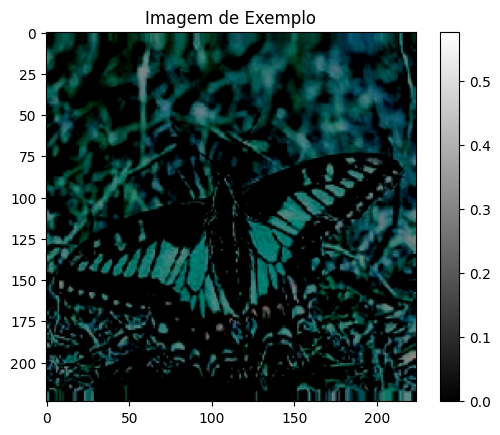

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


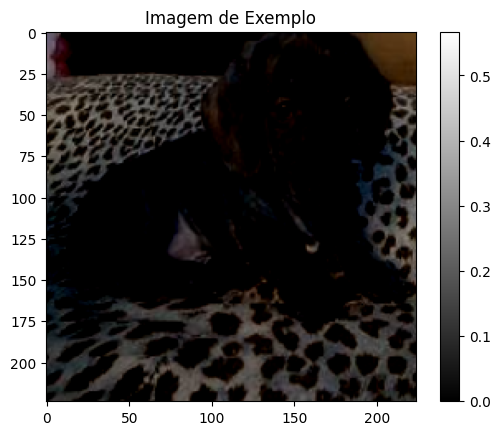

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


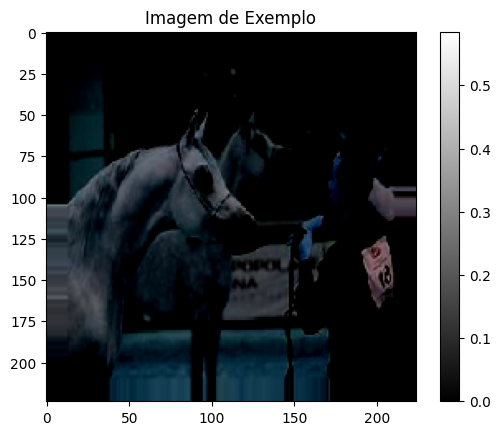

In [10]:
# Gera números para exibir imagens aleatóriamente
random_train_1 = np.random.randint(0, 286)
random_train_2 = np.random.randint(0, 31)

random_test_val_1 = np.random.randint(0, 61)
random_test_val_2 = np.random.randint(0, 20)

# Plota as imagens
plt.imshow(train_dataset[random_train_1][0][random_train_2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()
plt.imshow(test_dataset[random_test_val_1][0][random_test_val_2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()
plt.imshow(val_dataset[random_test_val_1][0][random_test_val_2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()

In [4]:
# Carregamento do modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela as camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Inclusão de camadas personalizadas no topo
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))  # Substitua 10 pelo número de suas classes

# Configuração e compilação o modelo
model.compile(optimizer=Adam(learning_rate=1e-7),  # Ajuste conforme necessário
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(train_dataset, epochs=30, batch_size=64, validation_data=val_dataset)  # Ajuste conforme necessário

model.summary()

Epoch 1/30
287/287 [==============================] - 1340s 5s/step - loss: 2.4668 - accuracy: 0.1007 - val_loss: 2.3349 - val_accuracy: 0.0961
Epoch 2/30
287/287 [==============================] - 1368s 5s/step - loss: 2.3685 - accuracy: 0.1161 - val_loss: 2.2498 - val_accuracy: 0.1264
Epoch 3/30
287/287 [==============================] - 1377s 5s/step - loss: 2.2995 - accuracy: 0.1422 - val_loss: 2.1948 - val_accuracy: 0.1901
Epoch 4/30
287/287 [==============================] - 1369s 5s/step - loss: 2.2528 - accuracy: 0.1708 - val_loss: 2.1528 - val_accuracy: 0.2520
Epoch 5/30
287/287 [==============================] - 1369s 5s/step - loss: 2.2136 - accuracy: 0.1987 - val_loss: 2.1237 - val_accuracy: 0.2711
Epoch 6/30
287/287 [==============================] - 1369s 5s/step - loss: 2.1836 - accuracy: 0.2200 - val_loss: 2.0876 - val_accuracy: 0.3027
Epoch 7/30
287/287 [==============================] - 1368s 5s/step - loss: 2.1566 - accuracy: 0.2373 - val_loss: 2.0619 - val_accuracy:

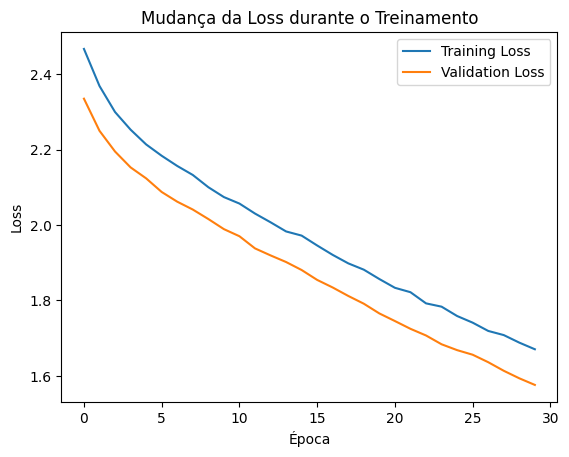

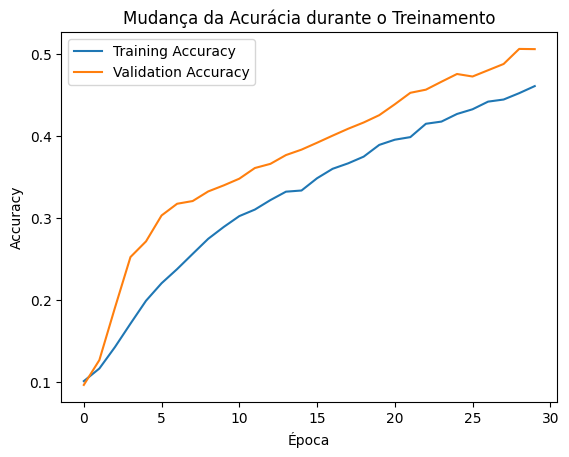

In [6]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# Plotagem da loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Mudança da Loss durante o Treinamento')
plt.legend()
plt.show()

# Plotagem da accuracy
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Mudança da Acurácia durante o Treinamento')
plt.legend()
plt.show()

In [11]:
# Define os nomes dos targets
target_names = ['Aranha', 'Borboleta', 'Cachorro', 'Cavalo', 'Elefante', 'Esquilo', 'Galinha', 'Gato', 'Ovelha', 'Vaca']

# Realiza a predição do conjunto de teste
predictions = model.predict(test_dataset)

# Obtém as classes preditas para cada amostra
y_pred = np.argmax(predictions, axis=1)

# Obtém as classes reais do conjunto de teste
y_true = test_dataset.classes

# Cria o relatório de classificação
report = classification_report(y_true, y_pred, target_names=target_names)

# Exibe o relatório de classificação
print(report)

for i in range(0, 61):
    print("Predito: ", y_pred[i], "Correto: ", y_true[i])

62/62 [==============================] - 246s 4s/step
              precision    recall  f1-score   support

      Aranha       0.18      0.35      0.24       723
   Borboleta       0.08      0.04      0.06       313
    Cachorro       0.20      0.39      0.26       730
      Cavalo       0.09      0.10      0.09       394
    Elefante       0.12      0.01      0.02       217
     Esquilo       0.33      0.00      0.01       280
     Galinha       0.09      0.07      0.08       465
        Gato       0.00      0.00      0.00       250
      Ovelha       0.06      0.00      0.01       273
        Vaca       0.09      0.03      0.05       280

    accuracy                           0.16      3925
   macro avg       0.12      0.10      0.08      3925
weighted avg       0.14      0.16      0.12      3925

Predito:  0 Correto:  0
Predito:  2 Correto:  0
Predito:  1 Correto:  0
Predito:  3 Correto:  0
Predito:  2 Correto:  0
Predito:  0 Correto:  0
Predito:  0 Correto:  0
Predito:  2 Correto